# Subject : Fraud Analytics Using Predictive and Social Network Techniques
# Course code : CS6890

## Assignment Number 3: Identifying outliers in the data by using Variational Autoencoders

### Group Members  
- **CS24MTECH14003** Anurag Sarva  
- **CS24MTECH14006** Gulshan Hatzade  
- **CS24MTECH14018** Mainak Adhikari  

finding optimal compression size...
Testing compression size 2...
Dimention 2: Reconstruction loss = 0.032387
Testing compression size 3...
Dimention 3: Reconstruction loss = 0.032273
Testing compression size 4...
Dimention 4: Reconstruction loss = 0.032323
Testing compression size 5...
Dimention 5: Reconstruction loss = 0.032324
Testing compression size 6...
Dimention 6: Reconstruction loss = 0.032374
Testing compression size 7...
Dimention 7: Reconstruction loss = 0.032341
Testing compression size 8...
Dimention 8: Reconstruction loss = 0.032294
Testing compression size 9...
Dimention 9: Reconstruction loss = 0.032494
Testing compression size 10...
Dimention 10: Reconstruction loss = 0.032386


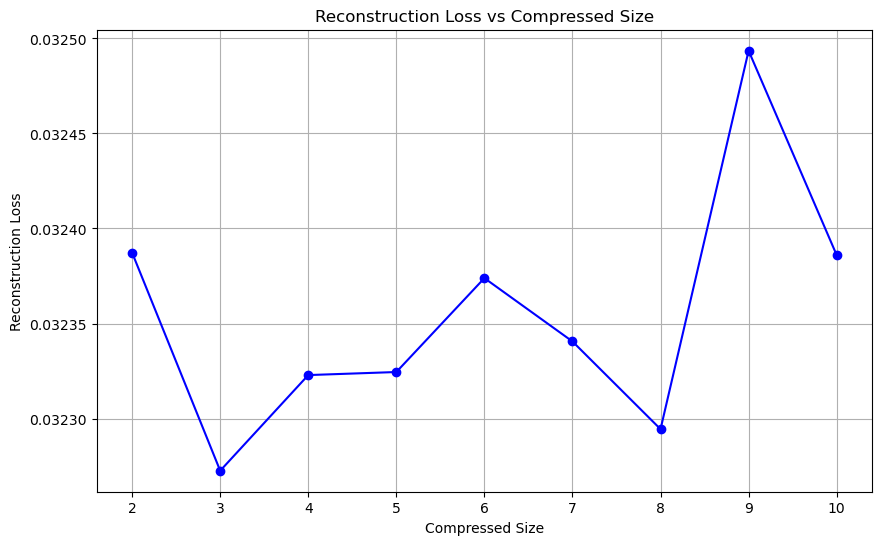

finding best dimention: 3

finding optimal cluster count...
Optimal clusters (elbow method): 2


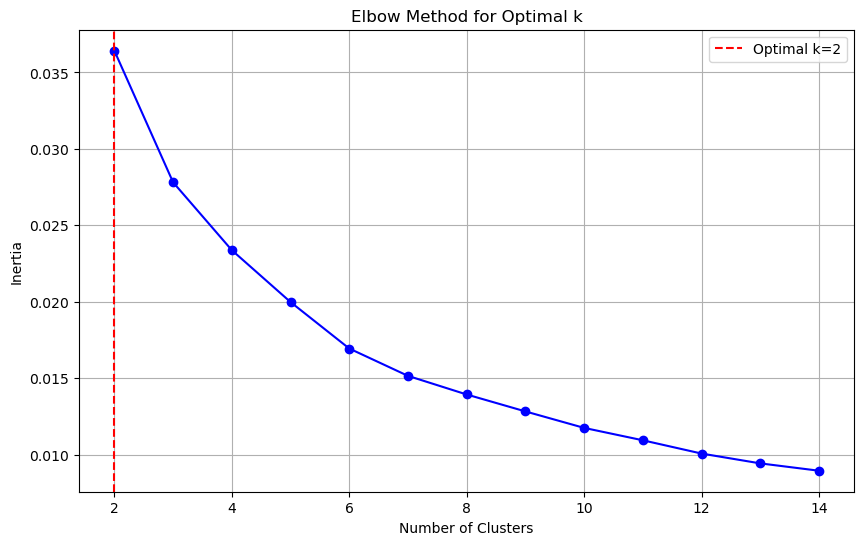

Using final k = 2
Group sizes: [815 384]
Small groups: []
Total outliers detected: 121
- Boundary outliers: 121
- Small cluster outliers: 0
Note: Using PCA to visualize higher dimensional compressed space in 2D


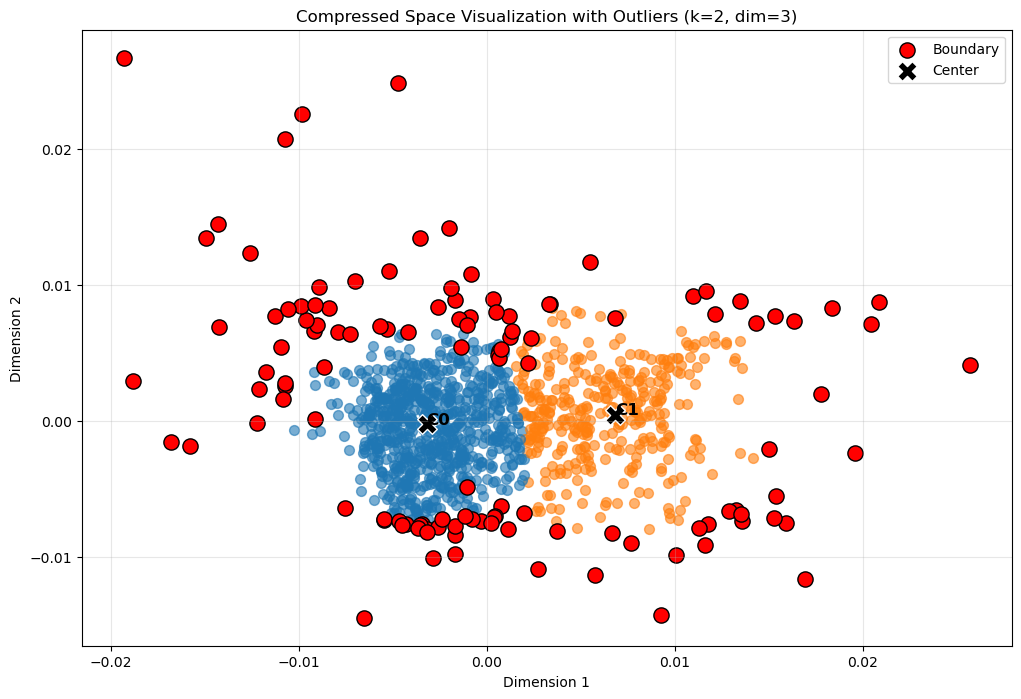


Table of Outliers from Original Data:

 Index  Group Outlier_Type  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  Feature_9  Feature_10
  1024      0     Boundary   0.996287   0.943707   0.637786   0.435098  -0.598050   0.853106   0.445108  -0.030675  -0.441364   -0.053432
     3      0     Boundary   0.396577   0.919933   0.496451   0.576824  -0.340718   0.802363   0.673710  -0.032058   0.449160   -0.054126
   260      0     Boundary   0.327020   0.327083  -0.519899  -0.519996   0.000000  -0.114690   0.973427  -0.033620  -0.311447   -0.053936
   263      0     Boundary   0.713135   0.311196   0.526621  -0.182596  -0.283029  -0.131136   0.053187  -0.032945  -0.698098   -0.053131
   775      0     Boundary   0.970067   0.959333   0.465860   0.331231   0.451480   0.470104   0.329265  -0.030511  -1.061069    0.058852
   266      0     Boundary   0.961760   0.536908   0.000000   0.000000  -0.343129   0.676358   0.974403  -0.030111   0.871556   -0.0

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import silhouette_score

# Making data ready for processing cleaning
# Removing any bad values converting to right type
# loading n normalizing data from csv file
raw_dataset = pd.read_csv('data.csv')
input_matrix = raw_dataset.values.astype(np.float32)
normalizer = MinMaxScaler()
normalized_data = normalizer.fit_transform(input_matrix)

# Making special neural network for finding hidden patterns
# This network squeezing data into smaller size then expanding back
class EncoderDecoder(nn.Module):
    def __init__(self, feature_size, compressed_size):
        # Setting up layers for squeezing data
        # using relu cuz it working good for most cases
        super(EncoderDecoder, self).__init__()
        self.encoder_layers = nn.Sequential(
            nn.Linear(feature_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.mean_layer = nn.Linear(16, compressed_size)
        self.variance_layer = nn.Linear(16, compressed_size)
        self.decoder_layers = nn.Sequential(
            nn.Linear(compressed_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, feature_size),
            nn.Sigmoid()
        )

    def noise_sampler(self, mean, log_var):
        # Adding bit of noise for making model more robust
        # Helping prevent overfitting n stuff
        std_dev = torch.exp(0.5 * log_var)
        noise = torch.randn_like(std_dev)
        return mean + noise * std_dev

    def forward(self, x):
        # Doing forward pass thru network
        # First squeezing then adding noise then expanding
        hidden = self.encoder_layers(x)
        mean = self.mean_layer(hidden)
        log_var = self.variance_layer(hidden)
        z = self.noise_sampler(mean, log_var)
        return self.decoder_layers(z), mean, log_var

# Function for training model n getting results
def train_model(feature_size, compressed_size, training_epochs=50):
    # Checking if gpu available for faster training
    # Setting everything up for training process
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = EncoderDecoder(feature_size=feature_size, compressed_size=compressed_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    dataset = TensorDataset(torch.tensor(normalized_data))
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Computing loss for checking performance
    def model_loss(recon_x, x, mean, log_var):
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return recon_loss + kl_div
    
    # Training loop going multiple times thru data
    model.train()
    epoch = 0
    while epoch < training_epochs:
        # Processing data in small chunks for memory saving
        # Updating model weights using gradient descent
        total_loss = 0
        batch_idx = 0
        n_batches = len(loader)
        while batch_idx < n_batches:
            batch = next(iter(loader))
            x = batch[0].to(device)
            optimizer.zero_grad()
            recon_x, mean, log_var = model(x)
            loss = model_loss(recon_x, x, mean, log_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_idx += 1
        epoch += 1
    
    # Compute reconstruction loss as performance metric
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(normalized_data).to(device)
        recon_x, mean, log_var = model(x_tensor)
        recon_loss = nn.functional.mse_loss(recon_x, x_tensor).item()
    
    return model, recon_loss, mean.cpu().numpy()

# Trying different sizes to see which one working best
print("finding optimal compression size...")
# Testing from small to big compression size
# Bigger not always better need to find good spot
dimension_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]
dimension_results = []
dim_idx = 0

while dim_idx < len(dimension_options):
    current_dim = dimension_options[dim_idx]
    print(f"Testing compression size {current_dim}...")
    model, reconstruction_error, _ = train_model(feature_size=normalized_data.shape[1], 
                                                 compressed_size=current_dim)
    print(f"Dimention {current_dim}: Reconstruction loss = {reconstruction_error:.6f}")
    dimension_results.append((current_dim, reconstruction_error))
    dim_idx += 1

# Making pretty picture to see how loss changing
# Lower loss meaning better compression quality
plt.figure(figsize=(10, 6))
dims, losses = zip(*dimension_results)
plt.plot(dims, losses, 'bo-')
plt.xlabel('Compressed Size')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss vs Compressed Size')
plt.grid(True)
plt.show()

# Finding best size using minimum reconstruction error
best_dim = min(dimension_results, key=lambda x: x[1])[0]
print(f"finding best dimention: {best_dim}")

# Training final model using best size what we found
final_model, _, compressed_space = train_model(feature_size=normalized_data.shape[1], compressed_size=best_dim)

# Doing clustering to find groups in data
# Using elbow method cuz it simple n effective
print("\nfinding optimal cluster count...")
# Trying different number of clusters to find best
cluster_errors = []
k_values = list(range(2, 15))
k_idx = 0

while k_idx < len(k_values):
    current_k = k_values[k_idx]
    clusterer = KMeans(n_clusters=current_k, random_state=0, n_init=10)
    clusterer.fit(compressed_space)
    cluster_errors.append(clusterer.inertia_)
    k_idx += 1

# Calculating rate of decrease in inertia for finding elbow point
diffs = np.diff(cluster_errors)
diff_ratios = diffs[:-1] / diffs[1:]
optimal_k_elbow = np.argmax(diff_ratios) + 2  

print(f"Optimal clusters (elbow method): {optimal_k_elbow}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, cluster_errors, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k={optimal_k_elbow}')
plt.legend()
plt.grid(True)
plt.show()

# Set final k based on elbow method
final_k = optimal_k_elbow
print(f"Using final k = {final_k}")

# Aplying kmeans with optimal k what we found
kmeans = KMeans(n_clusters=final_k, random_state=0, n_init=10)
group_labels = kmeans.fit_predict(compressed_space)
group_centers = kmeans.cluster_centers_
group_sizes = np.bincount(group_labels)

# Looking for points that not fitting well with others
# These points might be interesting or suspicious
# Two ways of finding outliers:
# 1. points in very small groups
# 2. points far from their group center
# Finding small groups less then 10% of avg size
avg_group_size = np.mean(group_sizes)
small_groups = [i for i, size in enumerate(group_sizes) if size < 0.3 * avg_group_size]
print(f"Group sizes: {group_sizes}")
print(f"Small groups: {small_groups}")

# Find points in small groups
small_group_points = set()
for i in range(len(compressed_space)):
    if group_labels[i] in small_groups:
        small_group_points.add(i)

# Find boundary points of big groups
boundary_points = set()
threshold_percentile = 90  # Points beyond 90th percentile of distances are boundary points

cluster_idx = 0
while cluster_idx < final_k:
    if cluster_idx in small_groups:
        cluster_idx += 1
        continue
    
    # Get points in this group
    group_points = np.where(group_labels == cluster_idx)[0]
    
    # Calculate distances to center
    center = group_centers[cluster_idx]
    point_distances = np.sqrt(np.sum((compressed_space[group_points] - center)**2, axis=1))
    
    # Find boundary points (points with distances beyond threshold_percentile)
    distance_threshold = np.percentile(point_distances, threshold_percentile)
    edge_points = group_points[point_distances > distance_threshold]
    
    # Add to boundary points
    boundary_points.update(edge_points)
    cluster_idx += 1

# Combine all outliers
all_outliers = boundary_points.union(small_group_points)
print(f"Total outliers detected: {len(all_outliers)}")
print(f"- Boundary outliers: {len(boundary_points)}")
print(f"- Small cluster outliers: {len(small_group_points)}")

# Create DataFrame from outlier results before display
outlier_records = []
for idx in all_outliers:
    outlier_type = 'Both' if idx in boundary_points and idx in small_group_points else \
                   'Boundary' if idx in boundary_points else 'Small Group'
    
    record = {
        'Index': idx,
        'Group': group_labels[idx],
        'Outlier_Type': outlier_type
    }
    # Add original feature values
    for col_idx, value in enumerate(raw_dataset.iloc[idx]):
        record[f'Feature_{col_idx+1}'] = value
        
    outlier_records.append(record)

# Create DataFrame and sort by outlier type and group
outlier_df = pd.DataFrame(outlier_records)
outlier_df = outlier_df.sort_values(['Outlier_Type', 'Group'])

# Making picture of results so humans can understand
# If data too big using pca to make it 2d
# Different colors n shapes for different types
# Visualising results in 2d space for seeing patterns
# Create a 2D projection for visualization if compressed size > 2
if best_dim > 2:
    # using pca for making high dimension data visible
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    compressed_2d = pca.fit_transform(compressed_space)
    print("Note: Using PCA to visualize higher dimensional compressed space in 2D")
else:
    compressed_2d = compressed_space

# Ploting normal points n outliers separate
plt.figure(figsize=(12, 8))
legend_handles = []  # To store handles for legend
legend_labels = []   # To store labels for legend

# Plot normal points
i = 0
while i < len(compressed_2d):
    if i not in all_outliers:
        plt.scatter(compressed_2d[i, 0], compressed_2d[i, 1], color=f'C{group_labels[i]}', alpha=0.6, s=50)
    i += 1

# Plot outliers with different markers
i = 0
while i < len(compressed_2d):
    if i in all_outliers:
        if i in boundary_points and i in small_group_points:
            marker = 'X'
            color = 'purple'
            label = 'Both'
            s = 150
        elif i in boundary_points:
            marker = 'o'
            color = 'red'
            label = 'Boundary'
            s = 120
        else:  # Small group outlier
            marker = '*'
            color = 'orange'
            label = 'Small Group'
            s = 150
            
        scatter = plt.scatter(compressed_2d[i, 0], compressed_2d[i, 1], marker=marker, color=color, 
                     s=s, edgecolors='black')
        
        if label not in legend_labels:
            legend_handles.append(scatter)
            legend_labels.append(label)
    i += 1

# Plot centers
i = 0
while i < len(group_centers):
    center = group_centers[i]
    if best_dim > 2:
        center_2d = pca.transform([center])[0]
    else:
        center_2d = center
    center_scatter = plt.scatter(center_2d[0], center_2d[1], marker='X', color='black', s=200, edgecolors='white')
    plt.annotate(f'C{i}', (center_2d[0], center_2d[1]), fontsize=12, fontweight='bold')
    
    if 'Center' not in legend_labels:
        legend_handles.append(center_scatter)
        legend_labels.append('Center')
    i += 1

plt.title(f'Compressed Space Visualization with Outliers (k={final_k}, dim={best_dim})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(legend_handles, legend_labels)
plt.grid(True, alpha=0.3)
plt.show()

# saving everything we found in nice table
# keeping track of which points are weird n why
# making csv file for sharing results with others
# showing detail table of outlier what we found

# Format and print the table with proper display
print("\nTable of Outliers from Original Data:")
pd.set_option('display.max_rows', None)  # Show all rows 
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content in each cell
print("\n", "="*80)  # Print separator line
print(outlier_df.to_string(index=False))  # Print full table without index
print("="*80)  # Print separator line

# Save outliers to CSV
print("\nSaving outliers to detected_outliers.csv...")
outlier_df.to_csv("detected_outliers.csv", index=False)
print("Save complete!")

# Print summary statistics
print("\nOutlier Summary:")
print("-"*40)
print(f"Total outliers found: {len(outlier_df)}")
print(f"Boundary outliers: {len(outlier_df[outlier_df['Outlier_Type']=='Boundary'])}")
print(f"Small cluster outliers: {len(outlier_df[outlier_df['Outlier_Type']=='Small Group'])}")
print("-"*40)